In [1]:
import community
print(community.__file__)


C:\Users\jainr\AppData\Local\Programs\Python\Python311\Lib\site-packages\community\__init__.py


In [35]:
import pandas as pd
import networkx as nx
import community.community_louvain as community_louvain
import nltk
from collections import defaultdict

nltk.download('punkt')

df = pd.read_excel("la_pairwise_similarity.xlsx")

global_similarity = defaultdict(dict)
threshold = 0.39

for _, row in df.iterrows():
    t1, t2, score = row["Tweet 1"], row["Tweet 2"], row["Similarity Score"]
    if score >= threshold:
        global_similarity[t1][t2] = score
        global_similarity[t2][t1] = score

# Step 3: Build the graph for Louvain detection
G = nx.Graph()
for t1 in global_similarity:
    for t2, score in global_similarity[t1].items():
        G.add_edge(t1, t2, weight=score)

# Step 4: Louvain community detection
partition = community_louvain.best_partition(G)

# Step 5: Group tweets by community
communities = defaultdict(list)
for tweet, comm_id in partition.items():
    communities[comm_id].append(tweet)

# Step 6: Weighted LexRank using pairwise similarity (not cosine)
def weighted_lexrank(sentences, threshold=0.39, top_k=65):
    if len(sentences) <= top_k:
        return sentences

    graph = nx.Graph()
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            t1, t2 = sentences[i], sentences[j]
            score = global_similarity.get(t1, {}).get(t2, 0)
            if score >= threshold:
                graph.add_edge(i, j, weight=score)

    if len(graph.nodes) == 0:
        return sentences[:top_k]

    scores = nx.pagerank(graph, weight='weight')
    ranked = sorted(((scores[i], sentences[i]) for i in scores), reverse=True)
    return [s for _, s in ranked[:top_k]]

# Step 7: Summarize each community using updated LexRank
community_summaries = {}
all_community_sentences = []

for comm_id, tweets in communities.items():
    unique_tweets = list(set(tweets))
    summary = weighted_lexrank(unique_tweets, threshold=0.39, top_k=65)
    community_summaries[f"Community_{comm_id}"] = summary
    all_community_sentences.extend(summary)

final_summary = weighted_lexrank(all_community_sentences, threshold=0.39, top_k=65)

# Step 9: Save summaries to Excel
with pd.ExcelWriter("community_summaries.xlsx") as writer:
    for name, summary in community_summaries.items():
        pd.DataFrame(summary, columns=["Summary"]).to_excel(writer, sheet_name=name[:31], index=False)
    pd.DataFrame(final_summary, columns=["Final Summary"]).to_excel(writer, sheet_name="Final_Summary", index=False)

print("✅ All community and final summaries saved to 'community_summaries.xlsx' using Weighted LexRank and pairwise similarity")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jainr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ All community and final summaries saved to 'community_summaries.xlsx' using Weighted LexRank and pairwise similarity


In [36]:

# Print number of tweets in each community
for cid, tweets in communities.items():
    print(f"Community {cid}: {len(tweets)} tweets")

Community 0: 319 tweets
Community 1: 308 tweets
Community 2: 275 tweets
Community 3: 29 tweets


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jainr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


👨 Matched Male Words & Frequencies:
god: 2
husband: 1
author: 1
fathers: 1
he: 1

👩 Matched Female Words & Frequencies:
women: 9
woman: 5
feminism: 3
mothers: 1
girl: 1
wife: 1
girls: 1
feminist: 1

🧮 Total Gendered Mentions: 28
📘 Weighted Male Score: 0.214286
📕 Weighted Female Score: 0.785714
📈 Weighted Inclusion Bias Score (female - male): 0.571429


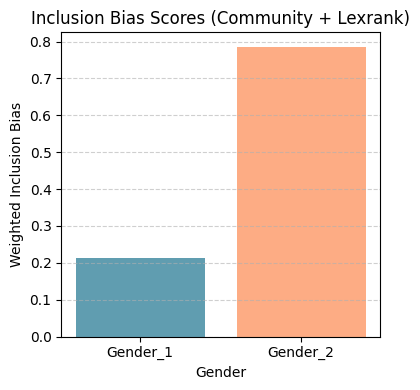

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

nltk.download('punkt')

# 📥 Load male and female word lists
male_words = pd.read_csv("male_list.csv", header=None)[0].str.lower().tolist()
female_words = pd.read_csv("female_list.csv", header=None)[0].str.lower().tolist()
male_set = set(male_words)
female_set = set(female_words)

# 📄 Load Final Summary from Excel
summary_df = pd.read_excel("community_summaries.xlsx", sheet_name="Final_Summary")
sentences = summary_df["Final Summary"].dropna().tolist()
combined_summary = " ".join(sentences)

# 🔧 Preprocess summary
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return word_tokenize(text)

tokens = preprocess(combined_summary)
word_freq = Counter(tokens)

# 🧮 Matched gendered terms and their counts
matched_male = {w: word_freq[w] for w in male_set if w in word_freq}
matched_female = {w: word_freq[w] for w in female_set if w in word_freq}

total_mentions = sum(matched_male.values()) + sum(matched_female.values())

if total_mentions == 0:
    male_score = female_score = bias_score = 0.0
else:
    male_score = sum(matched_male.values()) / total_mentions
    female_score = sum(matched_female.values()) / total_mentions
    bias_score = female_score - male_score

# 📢 Print frequencies
print("👨 Matched Male Words & Frequencies:")
for word, freq in sorted(matched_male.items(), key=lambda x: -x[1]):
    print(f"{word}: {freq}")

print("\n👩 Matched Female Words & Frequencies:")
for word, freq in sorted(matched_female.items(), key=lambda x: -x[1]):
    print(f"{word}: {freq}")

print(f"\n🧮 Total Gendered Mentions: {total_mentions}")
print(f"📘 Weighted Male Score: {male_score:.6f}")
print(f"📕 Weighted Female Score: {female_score:.6f}")
print(f"📈 Weighted Inclusion Bias Score (female - male): {bias_score:.6f}")

# 🖼️ Consistent Style Plot (Matching Previous Format)
plt.figure(figsize=(4, 4))  # Compact size like original
plt.bar(["Gender_1", "Gender_2"], [male_score, female_score], color=["#609db0", "#fdac84"])
plt.title("Inclusion Bias Scores (Community + Lexrank)")
plt.ylabel("Weighted Inclusion Bias")
plt.xlabel("Gender")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [2]:
!pip install scikit-learn


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 4.2 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/11.1 MB 3.4 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.1 MB 3.7 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.1 MB 3.9 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/11.1 MB 4.1 MB/s eta 0:00:02
   ---------------- ----------------------- 4.7/11.1 MB 4.1 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.1 MB 4.0 MB/s eta 0:00:02
   ---------------------- ----------------- 6.3/11.1 MB 4.1 MB/s eta 0:00:02
   -------------------------- ------------- 7.3/11.1 MB 4.2 MB/s eta 0:00:01
   ------------------------------- -------- 8.7/11.1 MB 4.4 MB/s eta 0:00:01
   ---------------------------------- ----- 9.7/11.1 MB 4.4 MB/s eta 0:00:01
   ------------------------------------- -- 10.5/11.1 MB 4.4 MB/s eta 0:00:01
   --